<a href="https://colab.research.google.com/github/mikeCode321/FetchMoreLanguageModel/blob/mlp_representation/fetchmore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this implementation of character level language modeling we will implement the Multi-Layer Perceptron (MLP). Represented by the Journal ->
*A Nueral Probabilistic Language Model*   Bengio et al.

Although, in this paper the authors do a word level model we will use the same principle, but for character level.

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [18]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [19]:
len(words)

32033

In [20]:
chars = sorted(list(set(''.join(words))))

In [21]:
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

The block size specifies the context in a rolling window fashion. Here we are just rolling over the 5 input words and shifting to the left 1 char, until the break char is reached == (.) or 0, inside the stoi mapping.

In [22]:
block_size = 3

X, y = [], []

for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


X holds the block size representation of Words[i] start with ... or 000.
Left shifted per i += 1 with the next chr of Words[i].

y holds the block size representation of the target chr after the starting '.' up until the ending '.'

In [23]:
X.shape, X.dtype, y.shape, y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [24]:
C = torch.randn((27, 2))

In [25]:
emb = C[X[:5]]

In [26]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [27]:
emb

tensor([[[-0.3993, -1.6973],
         [-0.3993, -1.6973],
         [-0.3993, -1.6973]],

        [[-0.3993, -1.6973],
         [-0.3993, -1.6973],
         [-0.9383,  0.1708]],

        [[-0.3993, -1.6973],
         [-0.9383,  0.1708],
         [ 0.6459, -2.7053]],

        [[-0.9383,  0.1708],
         [ 0.6459, -2.7053],
         [ 0.6459, -2.7053]],

        [[ 0.6459, -2.7053],
         [ 0.6459, -2.7053],
         [-0.8441, -1.2884]]])

In [28]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([5, 6])

In [29]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.3993, -1.6973, -0.3993, -1.6973, -0.3993, -1.6973],
        [-0.3993, -1.6973, -0.3993, -1.6973, -0.9383,  0.1708],
        [-0.3993, -1.6973, -0.9383,  0.1708,  0.6459, -2.7053],
        [-0.9383,  0.1708,  0.6459, -2.7053,  0.6459, -2.7053],
        [ 0.6459, -2.7053,  0.6459, -2.7053, -0.8441, -1.2884]])

In [30]:
emb.view(emb.shape[0], 6) ## better solution for flattening emb of each context

tensor([[-0.3993, -1.6973, -0.3993, -1.6973, -0.3993, -1.6973],
        [-0.3993, -1.6973, -0.3993, -1.6973, -0.9383,  0.1708],
        [-0.3993, -1.6973, -0.9383,  0.1708,  0.6459, -2.7053],
        [-0.9383,  0.1708,  0.6459, -2.7053,  0.6459, -2.7053],
        [ 0.6459, -2.7053,  0.6459, -2.7053, -0.8441, -1.2884]])

In [31]:
emb.view(emb.shape[0], 6) @ W1

tensor([[-1.4847e+00,  3.0064e+00,  3.9331e+00,  2.1541e+00,  3.9022e-01,
          4.9682e+00,  3.7227e+00,  3.8095e+00,  3.8988e+00, -3.0796e+00,
          1.9072e-01,  2.3525e+00, -2.7478e-01, -1.1345e+00,  2.4046e+00,
          2.0272e+00, -6.2726e+00, -2.1653e+00, -1.1891e+00, -7.2387e-01,
         -2.4998e+00, -5.3188e+00, -3.0440e+00,  2.0018e+00,  3.0805e+00,
          1.7814e+00,  6.8033e+00, -9.0554e-01, -3.4720e+00, -1.5319e+00,
          1.3131e+00, -1.1086e+00,  3.9287e+00, -6.0228e+00,  7.7642e-01,
          3.6255e+00,  5.5505e+00, -2.6317e+00,  3.1869e+00, -2.2426e+00,
         -6.5776e-01, -4.1246e+00, -1.5296e+00,  1.9149e+00, -2.7038e+00,
          4.1630e+00, -4.7200e+00, -1.5004e-01, -7.1447e-02,  1.4197e+00,
          2.3848e+00, -1.4183e+00,  6.0516e+00, -8.1644e-01,  1.7930e+00,
         -2.1995e+00, -5.7878e+00,  2.0441e+00, -2.9721e+00, -2.1205e+00,
          7.1457e-04,  7.1209e-01, -2.5314e+00, -4.3199e+00,  7.5132e-01,
          1.3169e+00, -1.5380e+00,  3.

In [32]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [33]:
h.shape

torch.Size([5, 100])

In [34]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [35]:
logits = h @ W2 + b2

In [36]:
logits.shape

torch.Size([5, 27])

In [37]:
counts = logits.exp()

In [38]:
prob = counts / counts.sum(dim=1, keepdims=True)

In [39]:
prob.shape

torch.Size([5, 27])

Negative log-likelihood

In [40]:
-prob[:, y].log().mean()

tensor(18.5757)

Putting everything done manually above, in a more iterative and configurable fashion.

In [41]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(dim=1, keepdims=True)
# loss = -prob[:, y].log().mean()
loss = F.cross_entropy(logits, y)

In [44]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

11897

In [45]:
def build_dataset(words):
  block_size = 3

  X, y = [], []

  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  y = torch.tensor(y)

  return X, y

## added train, val, test splits
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, ytr = build_dataset(words[:n1])
Xdev, ydev = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])

In [46]:
for p in parameters:
  p.requires_grad = True

In [47]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [48]:
lri = []
lossi = []
stepi = []

In [49]:

for i in range(100000):
  ix = torch.randint(0, Xtr.shape[0], (32,))

  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, ytr[ix])

  # print(loss.item())
  for p in parameters:
    p.grad = None

  loss.backward()
  # lr = lrs[i]
  lr = 0.1 if i < 50000 else 0.01 ## the exponent with the lowest loss
  for p in parameters:
    p.data += -lr * p.grad

  # lri.append(lre[i])
  # lossi.append(loss.item())
  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % 10000 == 0:
    print(f'{i:7d}/{100000:7d}: {loss.item():.4f}')

print(loss.item())

      0/ 100000: 25.6711
  10000/ 100000: 2.2734
  20000/ 100000: 2.8486
  30000/ 100000: 2.1523
  40000/ 100000: 2.4942
  50000/ 100000: 2.2523
  60000/ 100000: 2.6155
  70000/ 100000: 1.8049
  80000/ 100000: 2.0268
  90000/ 100000: 1.9459
2.326646327972412


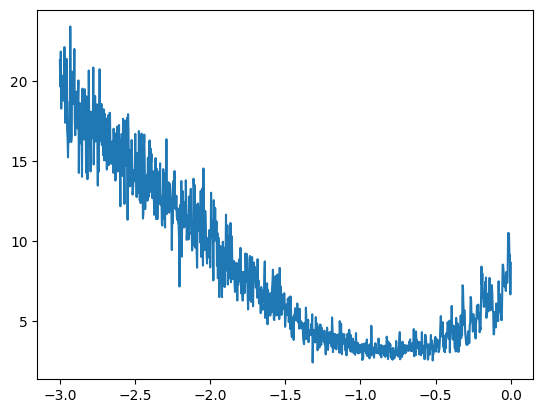

In [101]:
# plt.plot(lri, lossi)

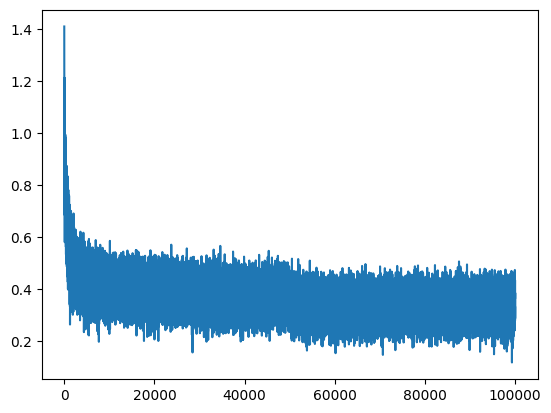

In [50]:
plt.plot(stepi, lossi)

In [51]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, ydev)
loss

tensor(2.2050, grad_fn=<NllLossBackward0>)

In [52]:
logits.max(1)

torch.return_types.max(
values=tensor([ 0.4925,  2.3632,  2.9848,  ...,  6.9310, 10.4568,  8.4291],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 14,  1,  ..., 12,  5, 14]))

In [53]:
ydev

tensor([ 1, 13,  1,  ..., 12,  1,  0])

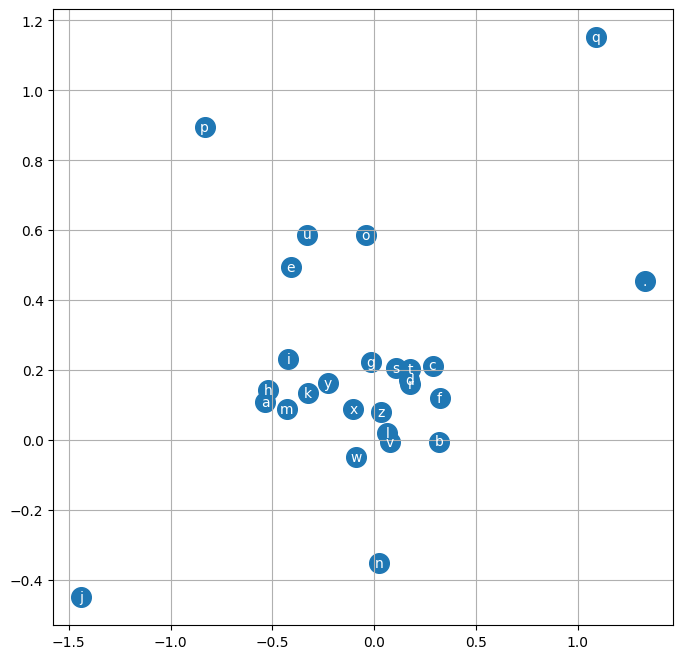

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

Sampling from the model

In [55]:

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mora.
amyannieel.
nihahala.
emmancendrajo.
aderydoelin.
shy.
jen.
edensenna.
araelyn.
malaia.
noshibergiagriest.
jairendy.
pxnterianu.
zen.
dariyah.
faehs.
kaysh.
stella.
hil.
aadyansuf.
